# Исследование кредитоспособности

### Исходные данные

В анализе используются реальные общедоступные данные **Home Mortgage HMDA** (Home Mortgage Disclosure Act), которые можно загрузить с официального [сайта](https://www.consumerfinance.gov/data-research/hmda/historic-data/?geo=nationwide&records=all-records&field_descriptions=codes), для объяснения и демонстрации ключевых концепций внедрения решений машинного обучения для выполнения анализа данных.

## Очистка и предобработка

In [27]:
import pandas as pd
import numpy as np

In [28]:
frame = pd.read_csv('./raw-data/hmda_2017_nationwide_all-records_codes.csv')
frame.shape

(14285496, 45)

В этих данных целевой переменной для прогнозирования процентной ставки является `rate_spread`. Первый простой шаг при сокращении выборки - определить, какие данные не подходят для данной цели, и убрать их. Мы будем использовать только те строки в данных, в которых спред ставки не пропущен.

In [29]:
frame = frame[frame['rate_spread'].notna()]
frame.shape

(493273, 45)

In [30]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 493273 entries, 37 to 14285441
Data columns (total 45 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   as_of_year                      493273 non-null  int64  
 1   respondent_id                   493273 non-null  object 
 2   agency_code                     493273 non-null  int64  
 3   loan_type                       493273 non-null  int64  
 4   property_type                   493273 non-null  int64  
 5   loan_purpose                    493273 non-null  int64  
 6   owner_occupancy                 493273 non-null  int64  
 7   loan_amount_000s                493095 non-null  float64
 8   preapproval                     493273 non-null  int64  
 9   action_taken                    493273 non-null  int64  
 10  msamd                           412807 non-null  float64
 11  state_code                      491191 non-null  float64
 12  county_code       

Опираясь на предположение о том, что столбцы с большим количеством пропусков не несут в себе существенной предсказательной способности, удалим их. Предел, после которого будет считать, что стобец можно удалить зададим через параметр `truncate_nan_threshold`.

In [31]:
truncate_nan_threshold = 0.5
frame = frame.loc[:, frame.isna().sum(axis=0) <= frame.shape[0] * truncate_nan_threshold]

In [33]:
frame = frame.loc[:, frame.nunique() > 1]

In [34]:
frame.nunique()

respondent_id                      3711
agency_code                           6
loan_type                             4
property_type                         2
loan_purpose                          3
owner_occupancy                       3
loan_amount_000s                   1626
preapproval                           3
msamd                               464
state_code                           52
county_code                         201
census_tract_number               21289
applicant_ethnicity                   4
co_applicant_ethnicity                5
applicant_race_1                      7
co_applicant_race_1                   8
applicant_sex                         4
co_applicant_sex                      5
applicant_income_000s              1340
purchaser_type                       10
rate_spread                         955
hoepa_status                          2
lien_status                           2
population                         9059
minority_population                9750


Разделим столбцы на типы данных для построения предсказаний. Примем столбцами с численным типом те, где количество уникальных значений более 100.

In [35]:
numerical_columns = frame.loc[:, frame.nunique()>100].select_dtypes(include=[np.number]).columns
categorical_columns = [column for column in frame.columns if not column in numerical_columns]

## Выборка данных

В большинстве случаев невозможно работать с полной совокупностью данных - либо она недоступна, либо объем данных делает работу с ней нецелесообразной. Работая с выборками данных, можно делать выводы и заключения о всем наборе данных, из которой взяты эти выборки. 

Работа с выборочными данными влечет за собой так называемую ошибку выборки, и существуют методы измерения этой ошибки. При работе с выборками мы предполагаем, что результаты, полученные на основе выборочных данных, обусловлены ошибкой выборки и эти результаты не верны для всей совокупности. Это предположение называется нулевой гипотезой. Статистические методы используются для измерения того, насколько вероятно, что нулевая гипотеза может быть верна, и именно об этом нам говорит проверка значимости по `p-value`.

В библиотеке `scipy` Python есть необходимые функции для вычисления `p-value`.

In [55]:
from scipy.stats import ks_2samp

Как правило, значение 

$$p < 5 \% (< 0.05)$$

означает, что мы можем отвергнуть нулевую гипотезу. Функция `scipy.stats.ks_2samp` при использовании с опцией `alternative=two-sided` соответствует нулевой гипотезе, что распределения данных выборки и полного набора данных идентичны, и альтернативной гипотезе, что они не идентичны.

Простая случайная выборка довольно легко выполнима и является наиболее простым методом вероятностной выборки. Однако существует риск возникновения смещения выборки.

In [36]:
sample_frame = frame.sample(n=int(frame.shape[0] / 5))

pvalue_dict = {}
for col in frame.columns:
    sample_column = sample_frame[col].dropna()
    frame_column = frame[col].dropna()

    sample_frame_pvalue = ks_2samp(
        sample_column, 
        frame_column, 
        alternative='two-sided',
        mode='auto'
    )[1]
    pvalue_dict[col] = sample_frame_pvalue

pvalue_frame = pd.DataFrame(
    pvalue_dict,
    index=['P-Value'],
).transpose().sort_values(by='P-Value')

pvalue_frame

P-Value
respondent_id                   0.415978
population                      0.577658
rate_spread                     0.713098
number_of_1_to_4_family_units   0.733173
minority_population             0.743982
state_code                      0.776662
county_code                     0.875747
tract_to_msamd_income           0.886776
msamd                           0.918233
hud_median_family_income        0.962022
census_tract_number             0.967550
applicant_sex                   0.981466
loan_amount_000s                0.990663
co_applicant_sex                0.992624
applicant_income_000s           0.997691
agency_code                     0.998713
number_of_owner_occupied_units  0.999955
loan_type                       0.999955
purchaser_type                  0.999979
applicant_ethnicity             0.999994
co_applicant_ethnicity          0.999997
co_applicant_race_1             1.000000
preapproval                     1.000000
owner_occupancy                 1.000000
property_type                   1.000000
loan_purpose                    1.000000
hoepa_status                    1.000000
lien_status                     1.000000
applicant_race_1                1.000000

Как можно заметить выше, значения `p-value`, полученные при сравнении выборочных данных с данными полной популяции, очень высоки - в диапазоне $40-100\%$, - следовательно, нулевая гипотеза не может быть отвергнута, а значит, полученные выборочные данные действительно являются репрезентативными для полного набора данных.

В качестве альтернативы можно сказать, что выборочные данные не несут заметной ошибки выборки, а результаты, полученные при использовании таких выборочных данных, будут справедливы и для всей популяции.

In [38]:
import gc

frame = sample_frame

gc.collect()

2352

## Визуальный анализ данных

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 


plt.style.use('ggplot')

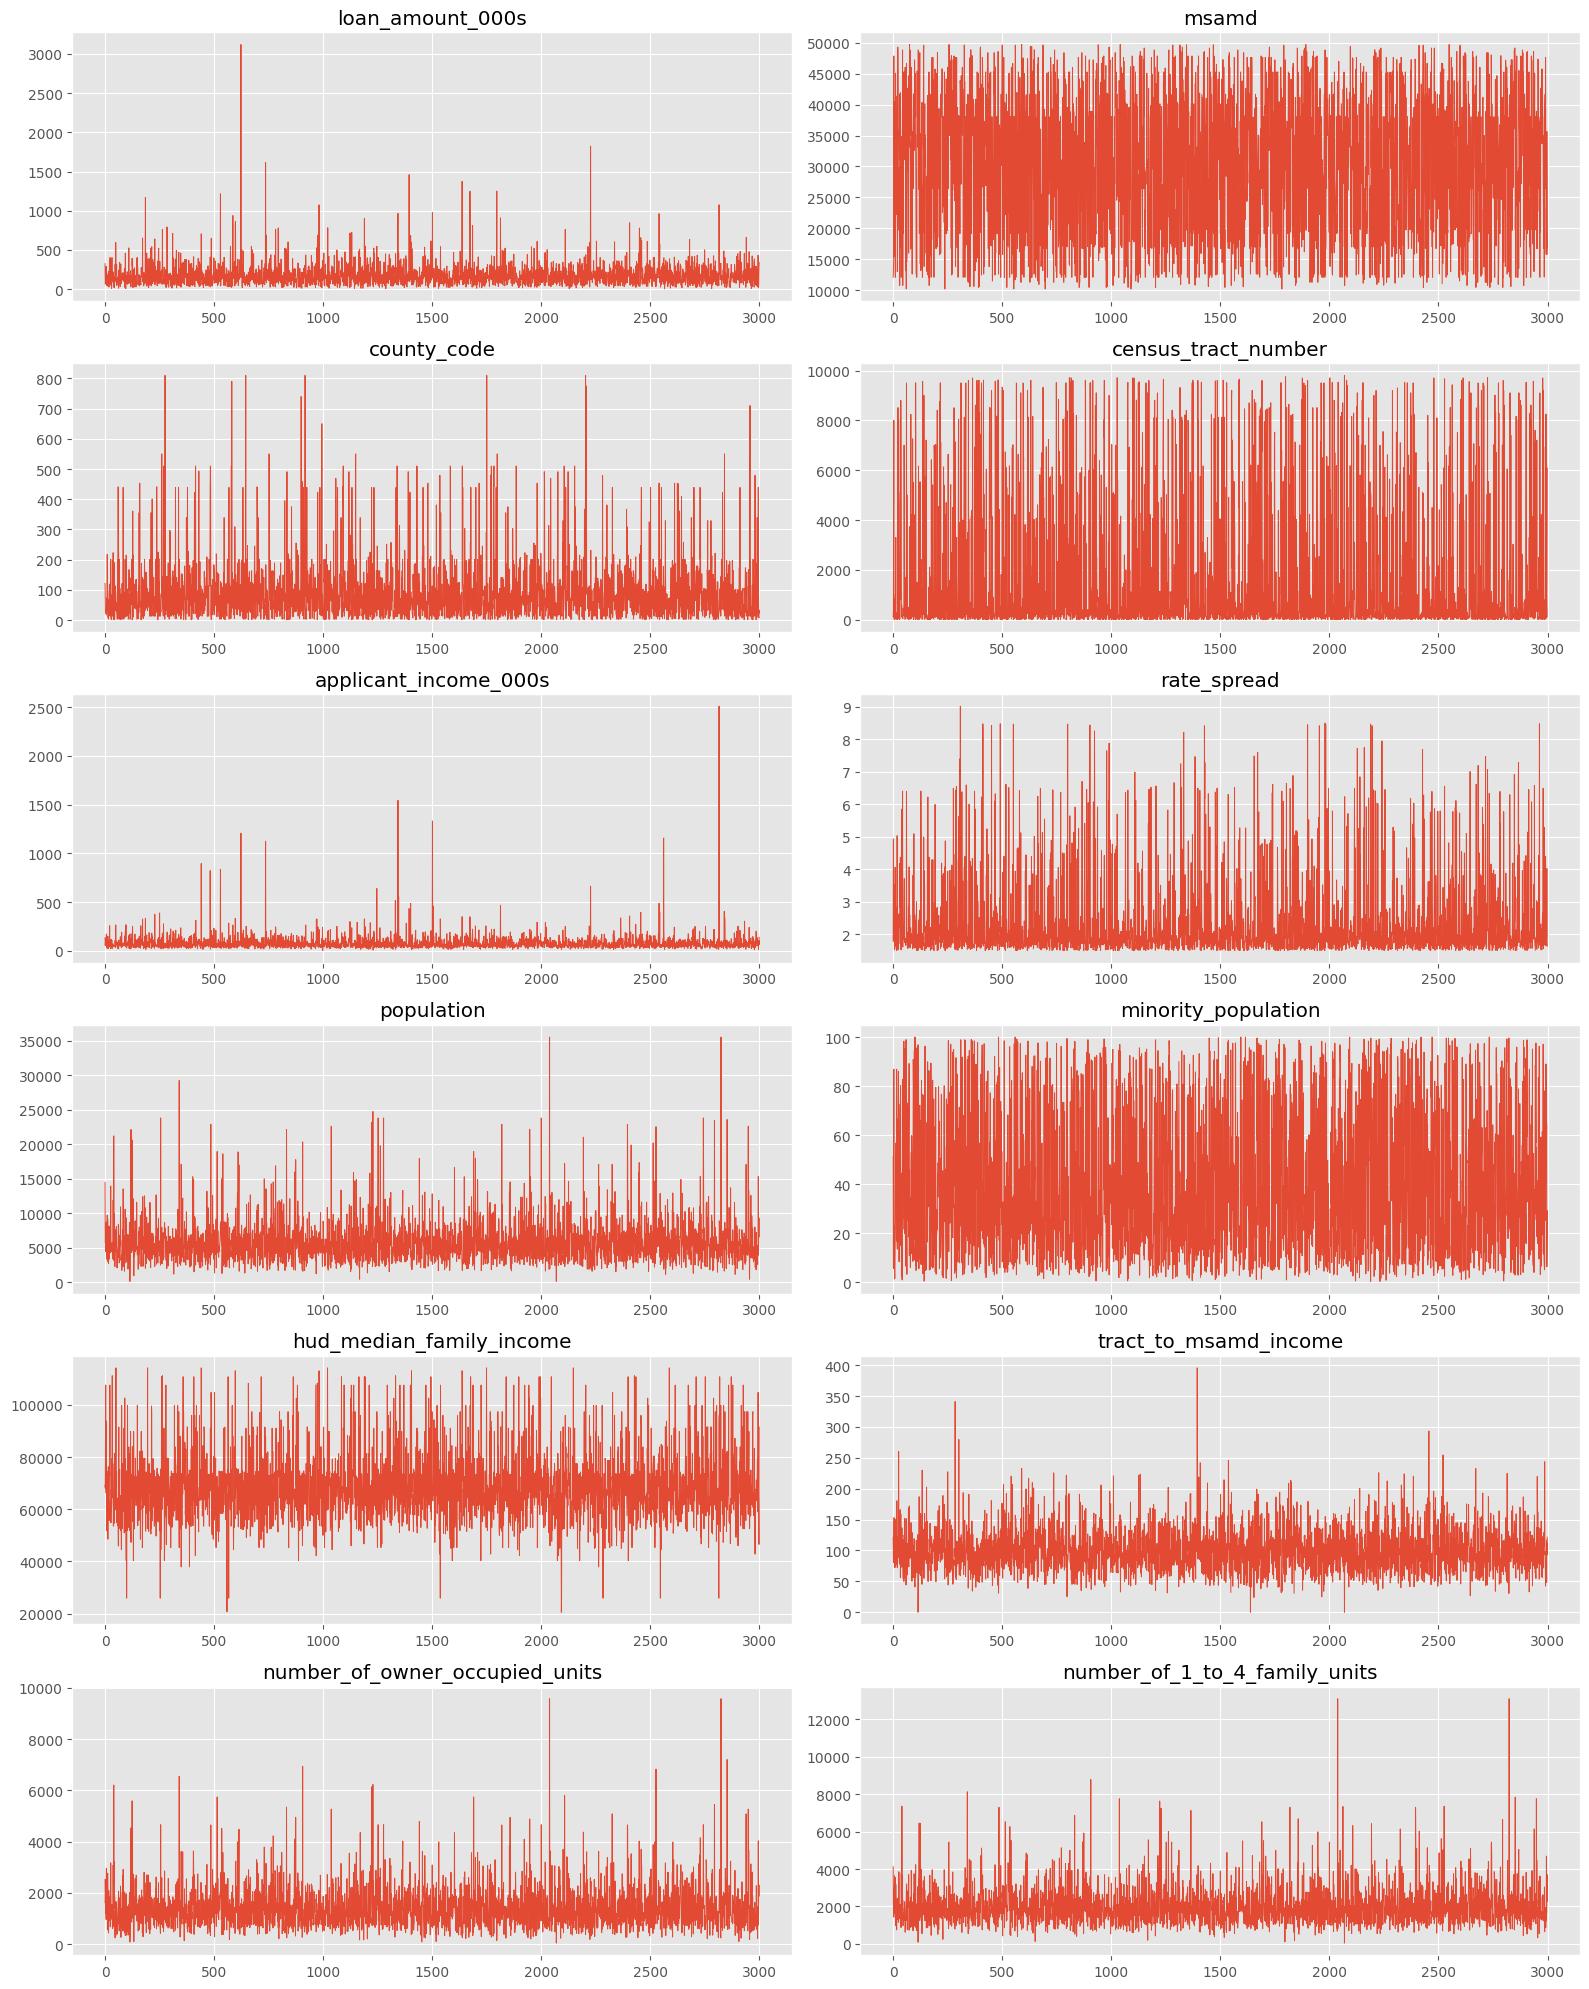

In [40]:
fig, axs = plt.subplots(
    nrows=int(np.ceil(len(numerical_columns)/2)), 
    ncols=2,
    figsize=(16, 20)
)
axs = axs.flatten()

frame_plot_slice = frame.iloc[-3000:].reset_index(drop=True)

for i, num_col in enumerate(numerical_columns):
    frame_plot_slice[num_col].plot(ax=axs[i], linewidth=0.7)
    axs[i].set_title(num_col)

fig.tight_layout()
plt.show()

## Удаление выбросов

На графическом представлении числовых переменных можно увидеть ряд проблем с данными, таких как выбросы и смешанное масштабирование. Визуализация данных, содержащих значительные выбросы, мало что объяснит о закономерностях данных, поэтому стоит удалить эти самые выбросы.

Общепринятой практикой выявления выбросов по отношению к нормальному распределению является рассмотрение трёх стандартных отклонений и `zscore` из модуля `scipy.stats`.

In [57]:
from scipy.stats import zscore

zscore_threshold = 3

Значение порога для отсечения задано с помощью переменной `zscore_threshold`.

In [41]:
initial_shape = frame.shape

frame = frame[(np.abs(zscore(frame[numerical_columns])) <= zscore_threshold).all(axis=1)]

no_outliers_shape = frame.shape

print(f'Удалено {initial_shape[0]-no_outliers_shape[0]}.')

Deleted 10348.


### TODO

In [ ]:
categorical_columns.remove('respondent_id')

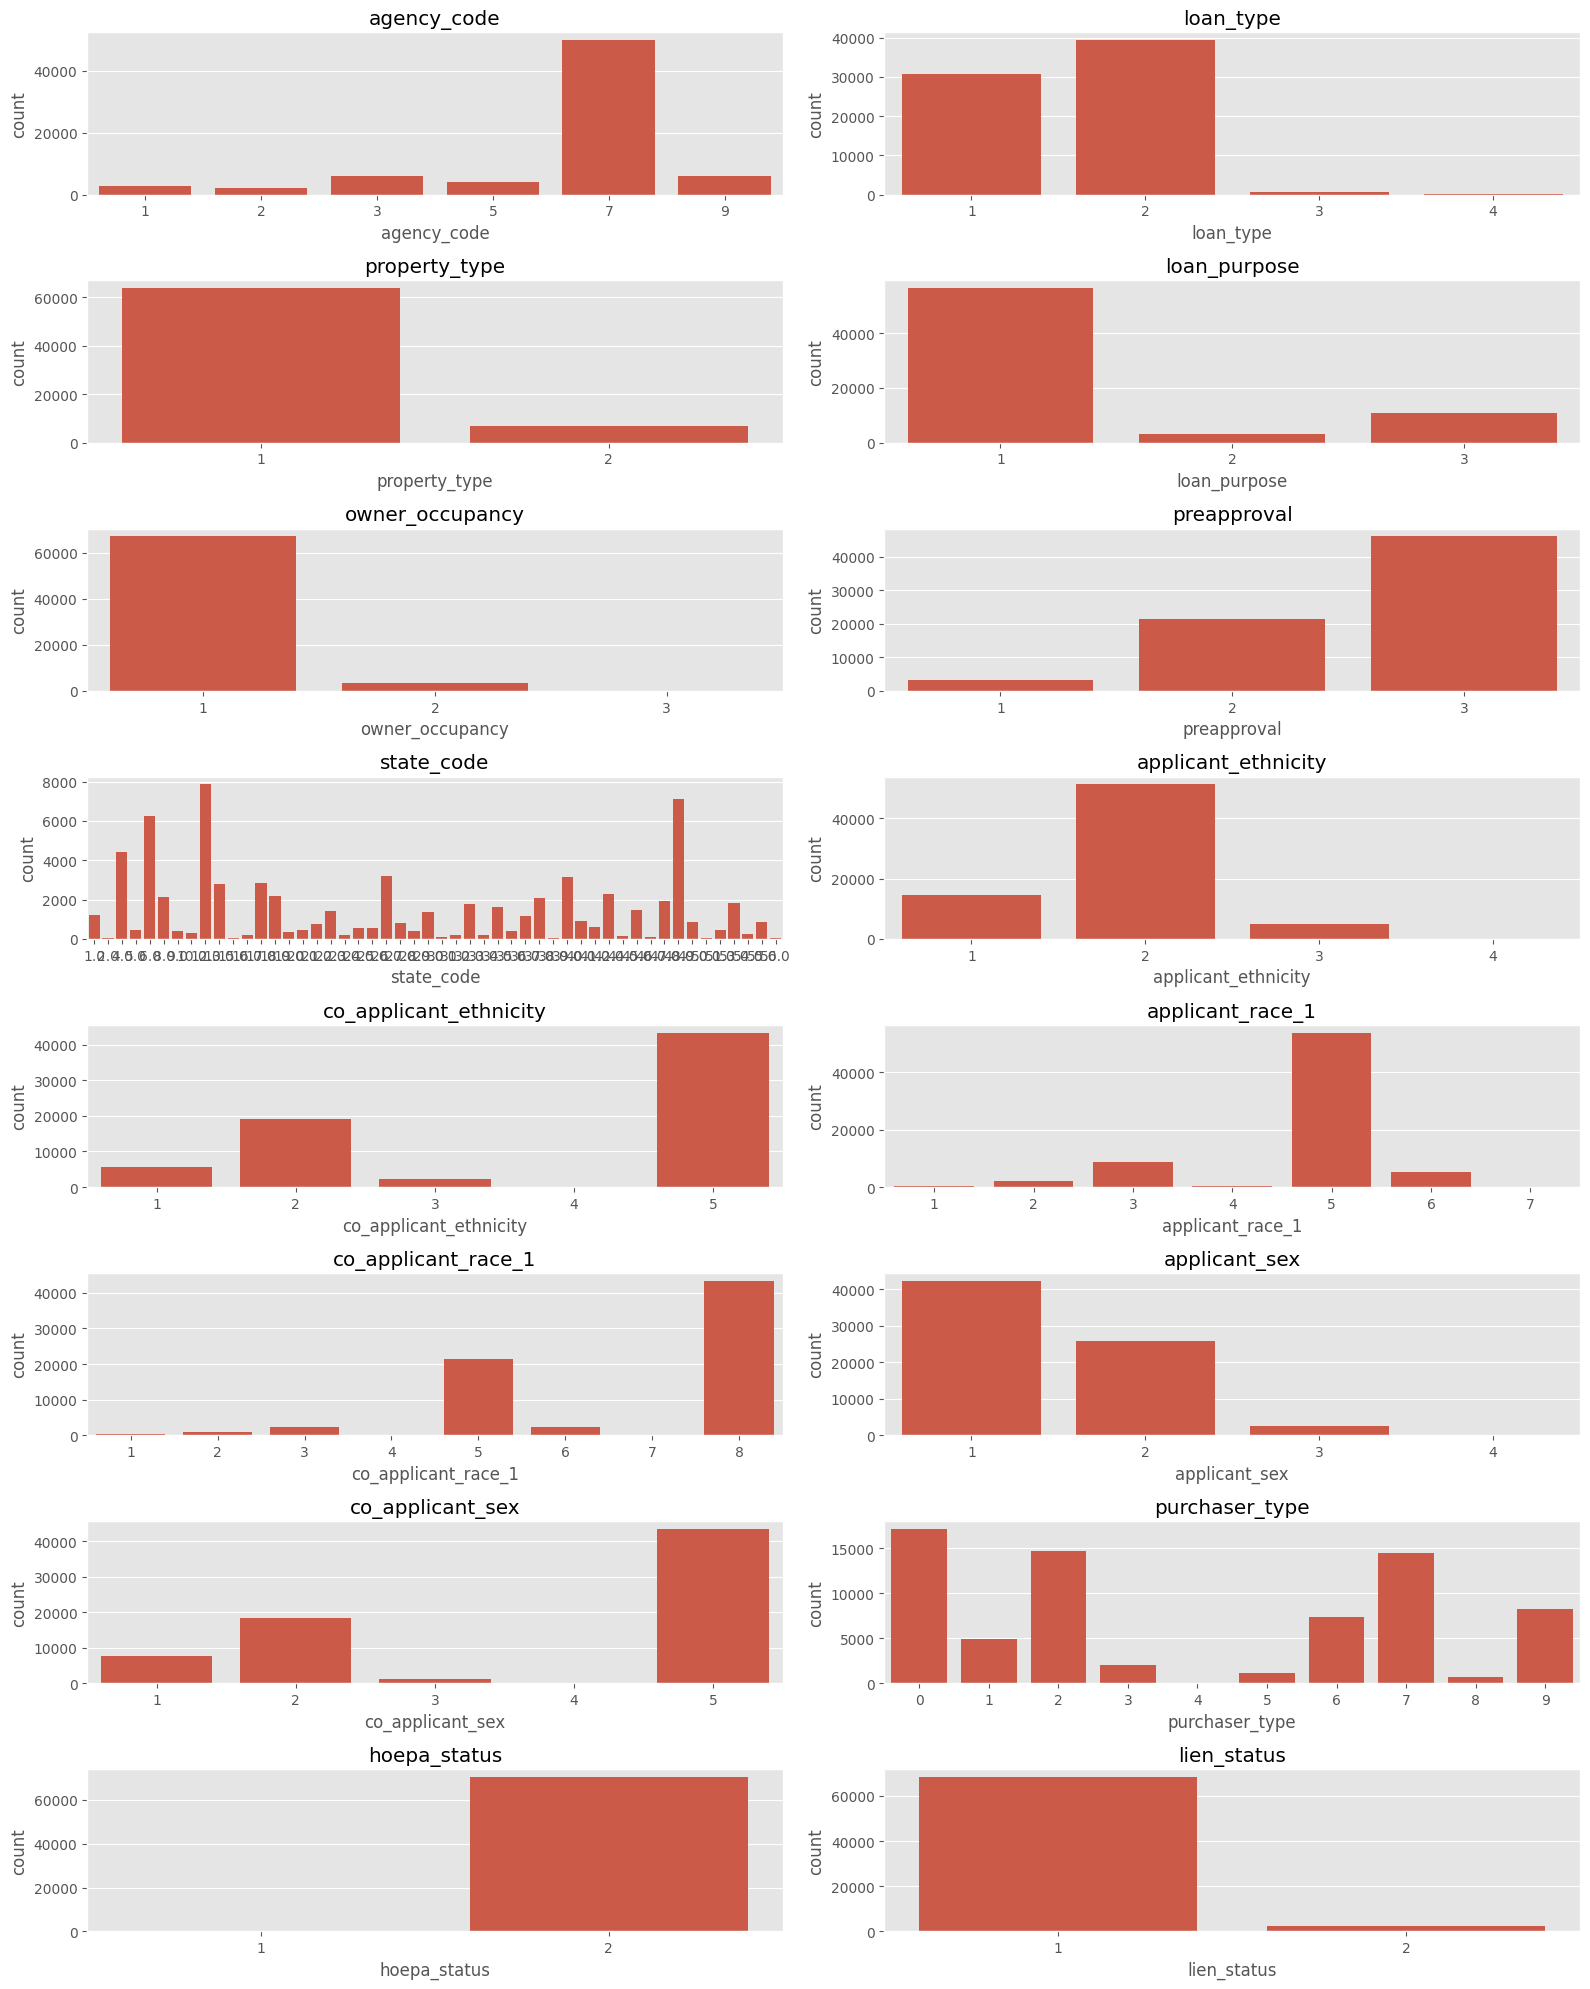

In [43]:
fig, axs = plt.subplots(
    nrows=int(np.ceil(len(categorical_columns)/2)), 
    ncols=2,
    figsize=(16, 20)
)
axs = axs.flatten()

for i, cat_col in enumerate(categorical_columns):
    sns.countplot(
        data=frame, 
        x=cat_col, 
        ax=axs[i]
    )
    axs[i].set_title(cat_col)

fig.tight_layout()
plt.show()

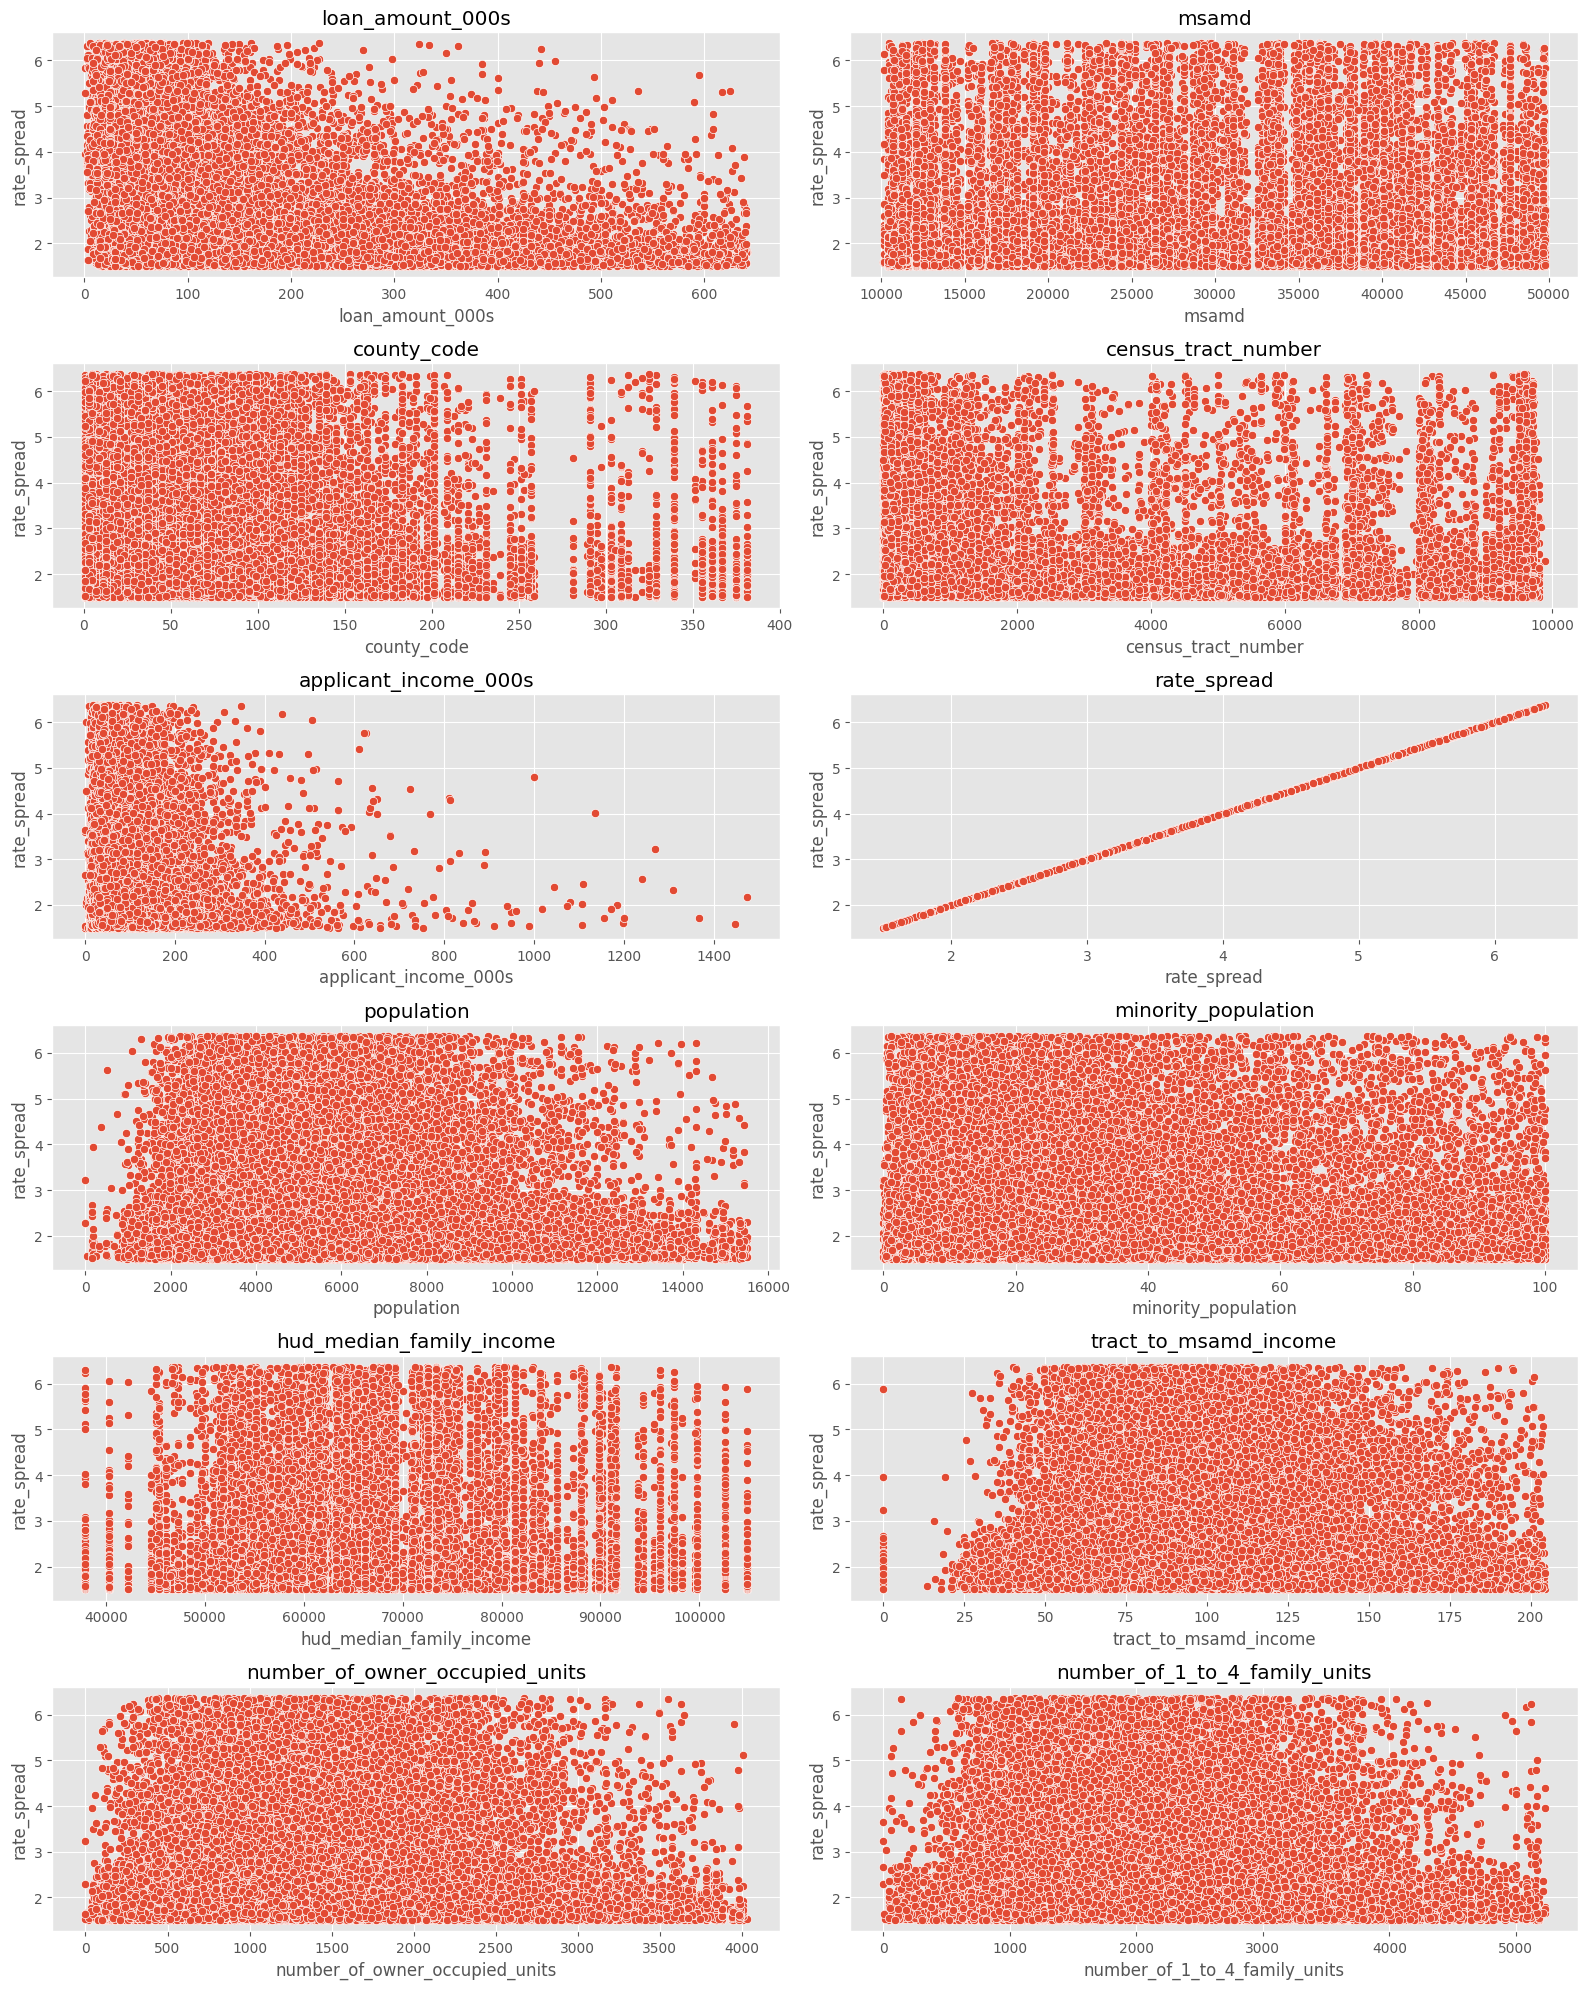

In [44]:
fig, axs = plt.subplots(
    nrows=int(np.ceil(len(numerical_columns)/2)), 
    ncols=2,
    figsize=(16, 20)
)
axs = axs.flatten()

for i, num_col in enumerate(numerical_columns):
    sns.scatterplot(
        data=frame, 
        x=num_col, 
        y='rate_spread', 
        ax=axs[i]
    )
    axs[i].set_title(num_col)

fig.tight_layout()
plt.show()

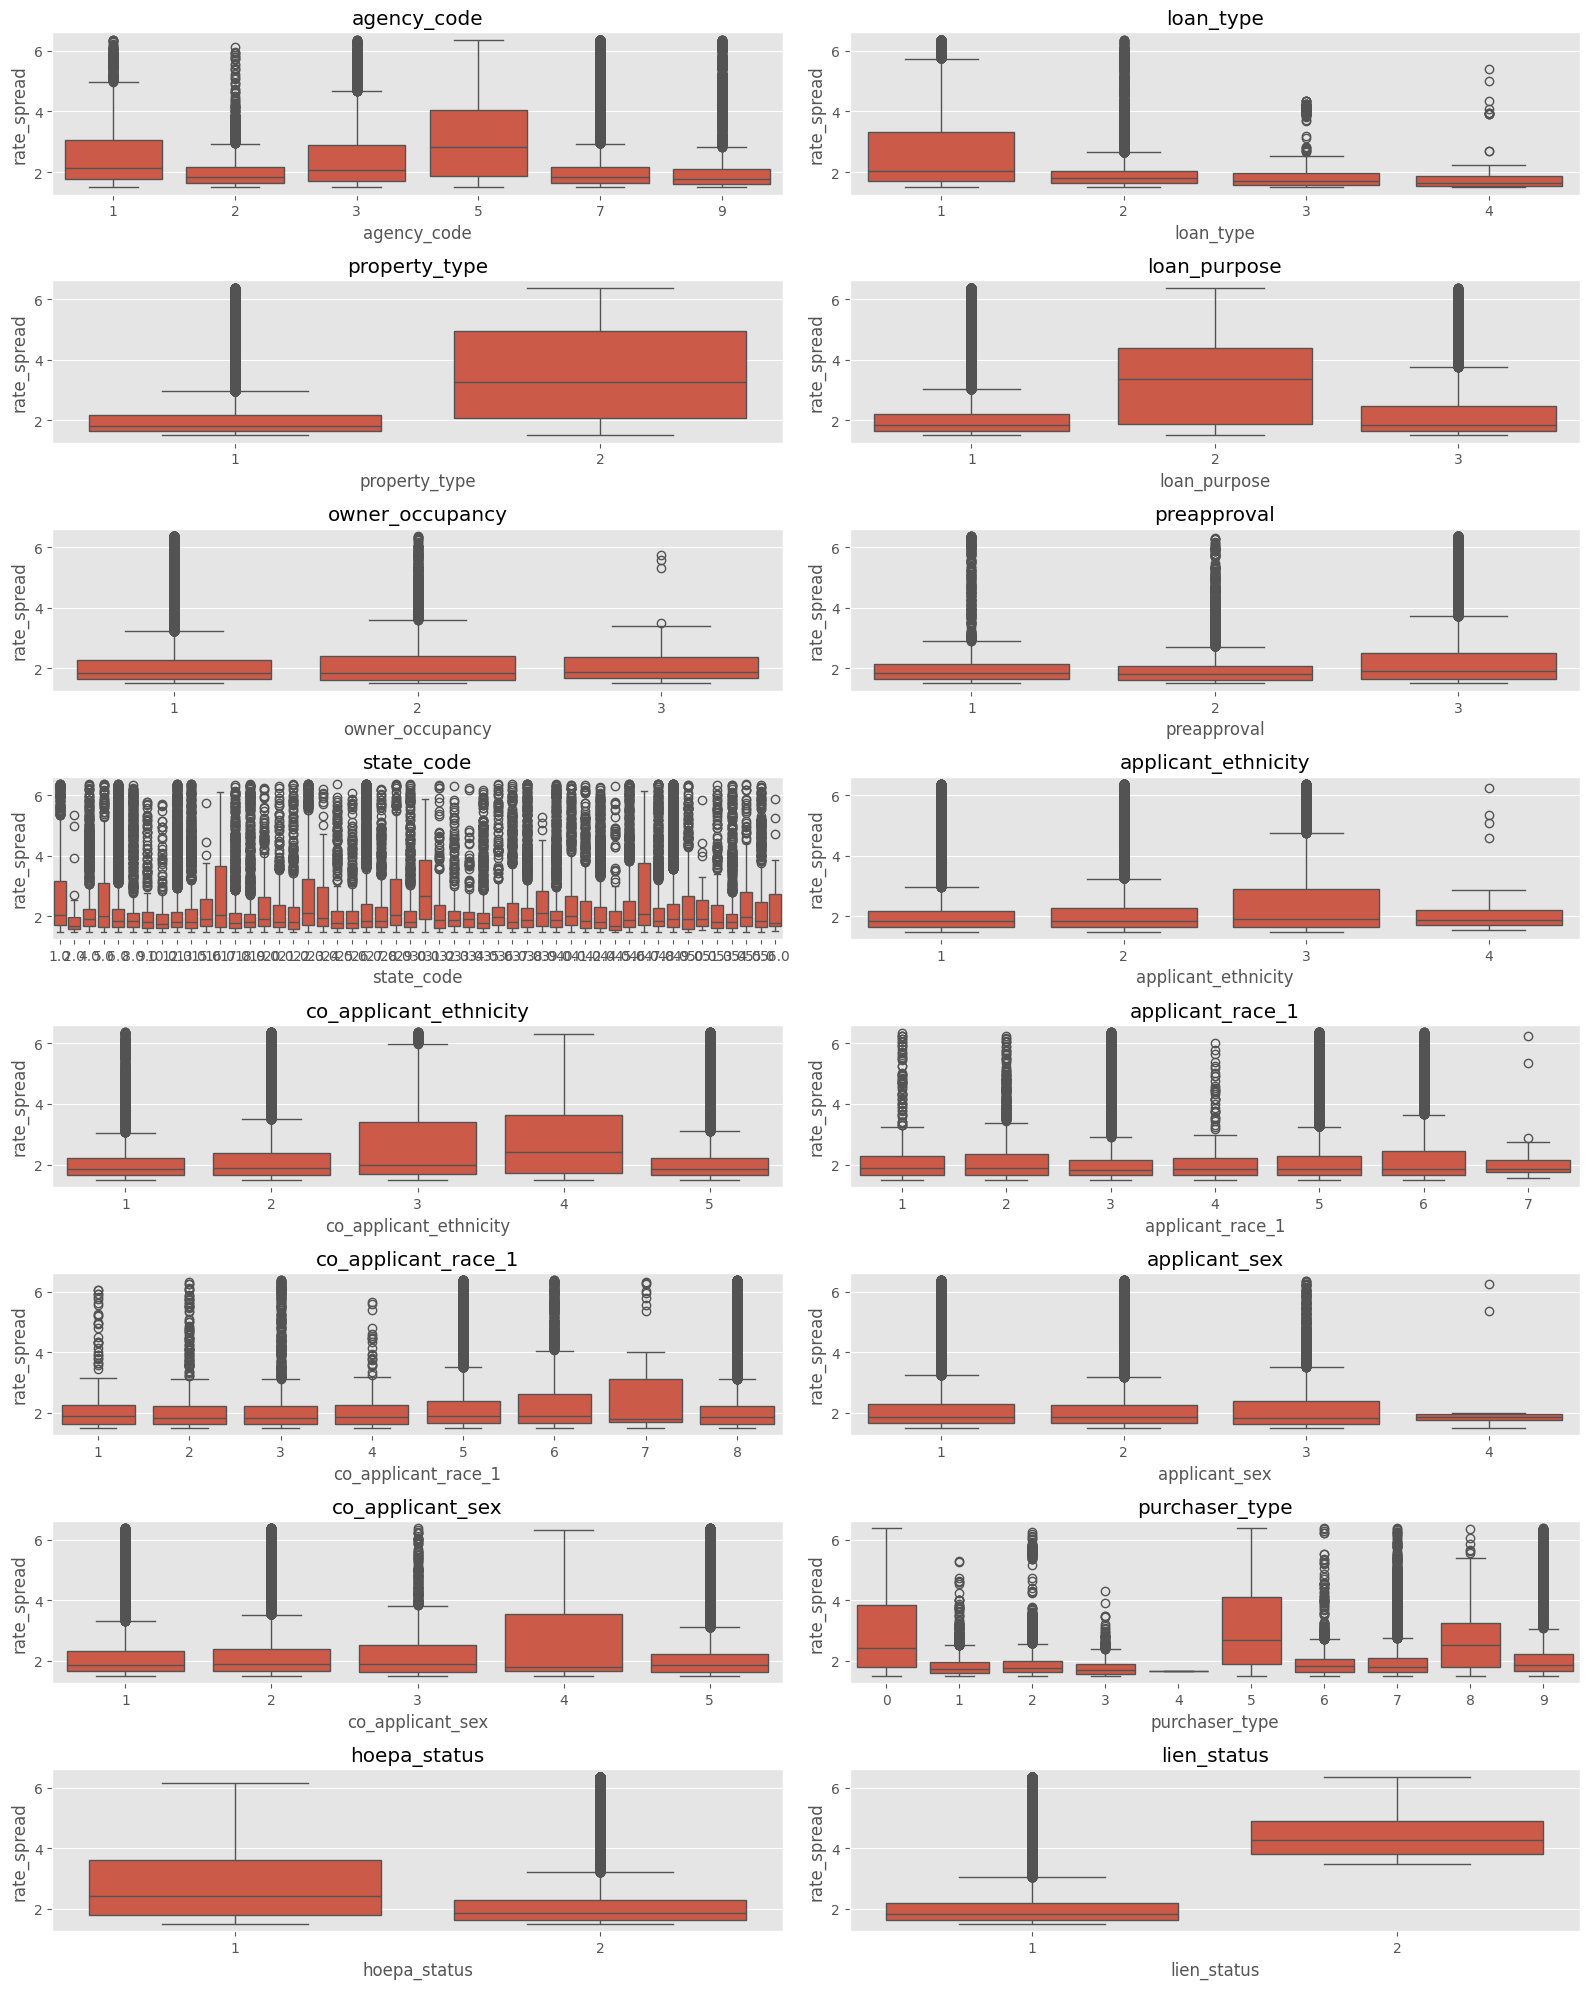

In [48]:
fig, axs = plt.subplots(
    nrows=int(np.ceil(len(categorical_columns)/2)), 
    ncols=2,
    figsize=(16, 20)
)
axs = axs.flatten()

for i, cat_col in enumerate(categorical_columns):
    sns.boxplot(
        data=frame, 
        x=cat_col, 
        y='rate_spread', 
        ax=axs[i]
    )
    axs[i].set_title(cat_col)

fig.tight_layout()
plt.show()

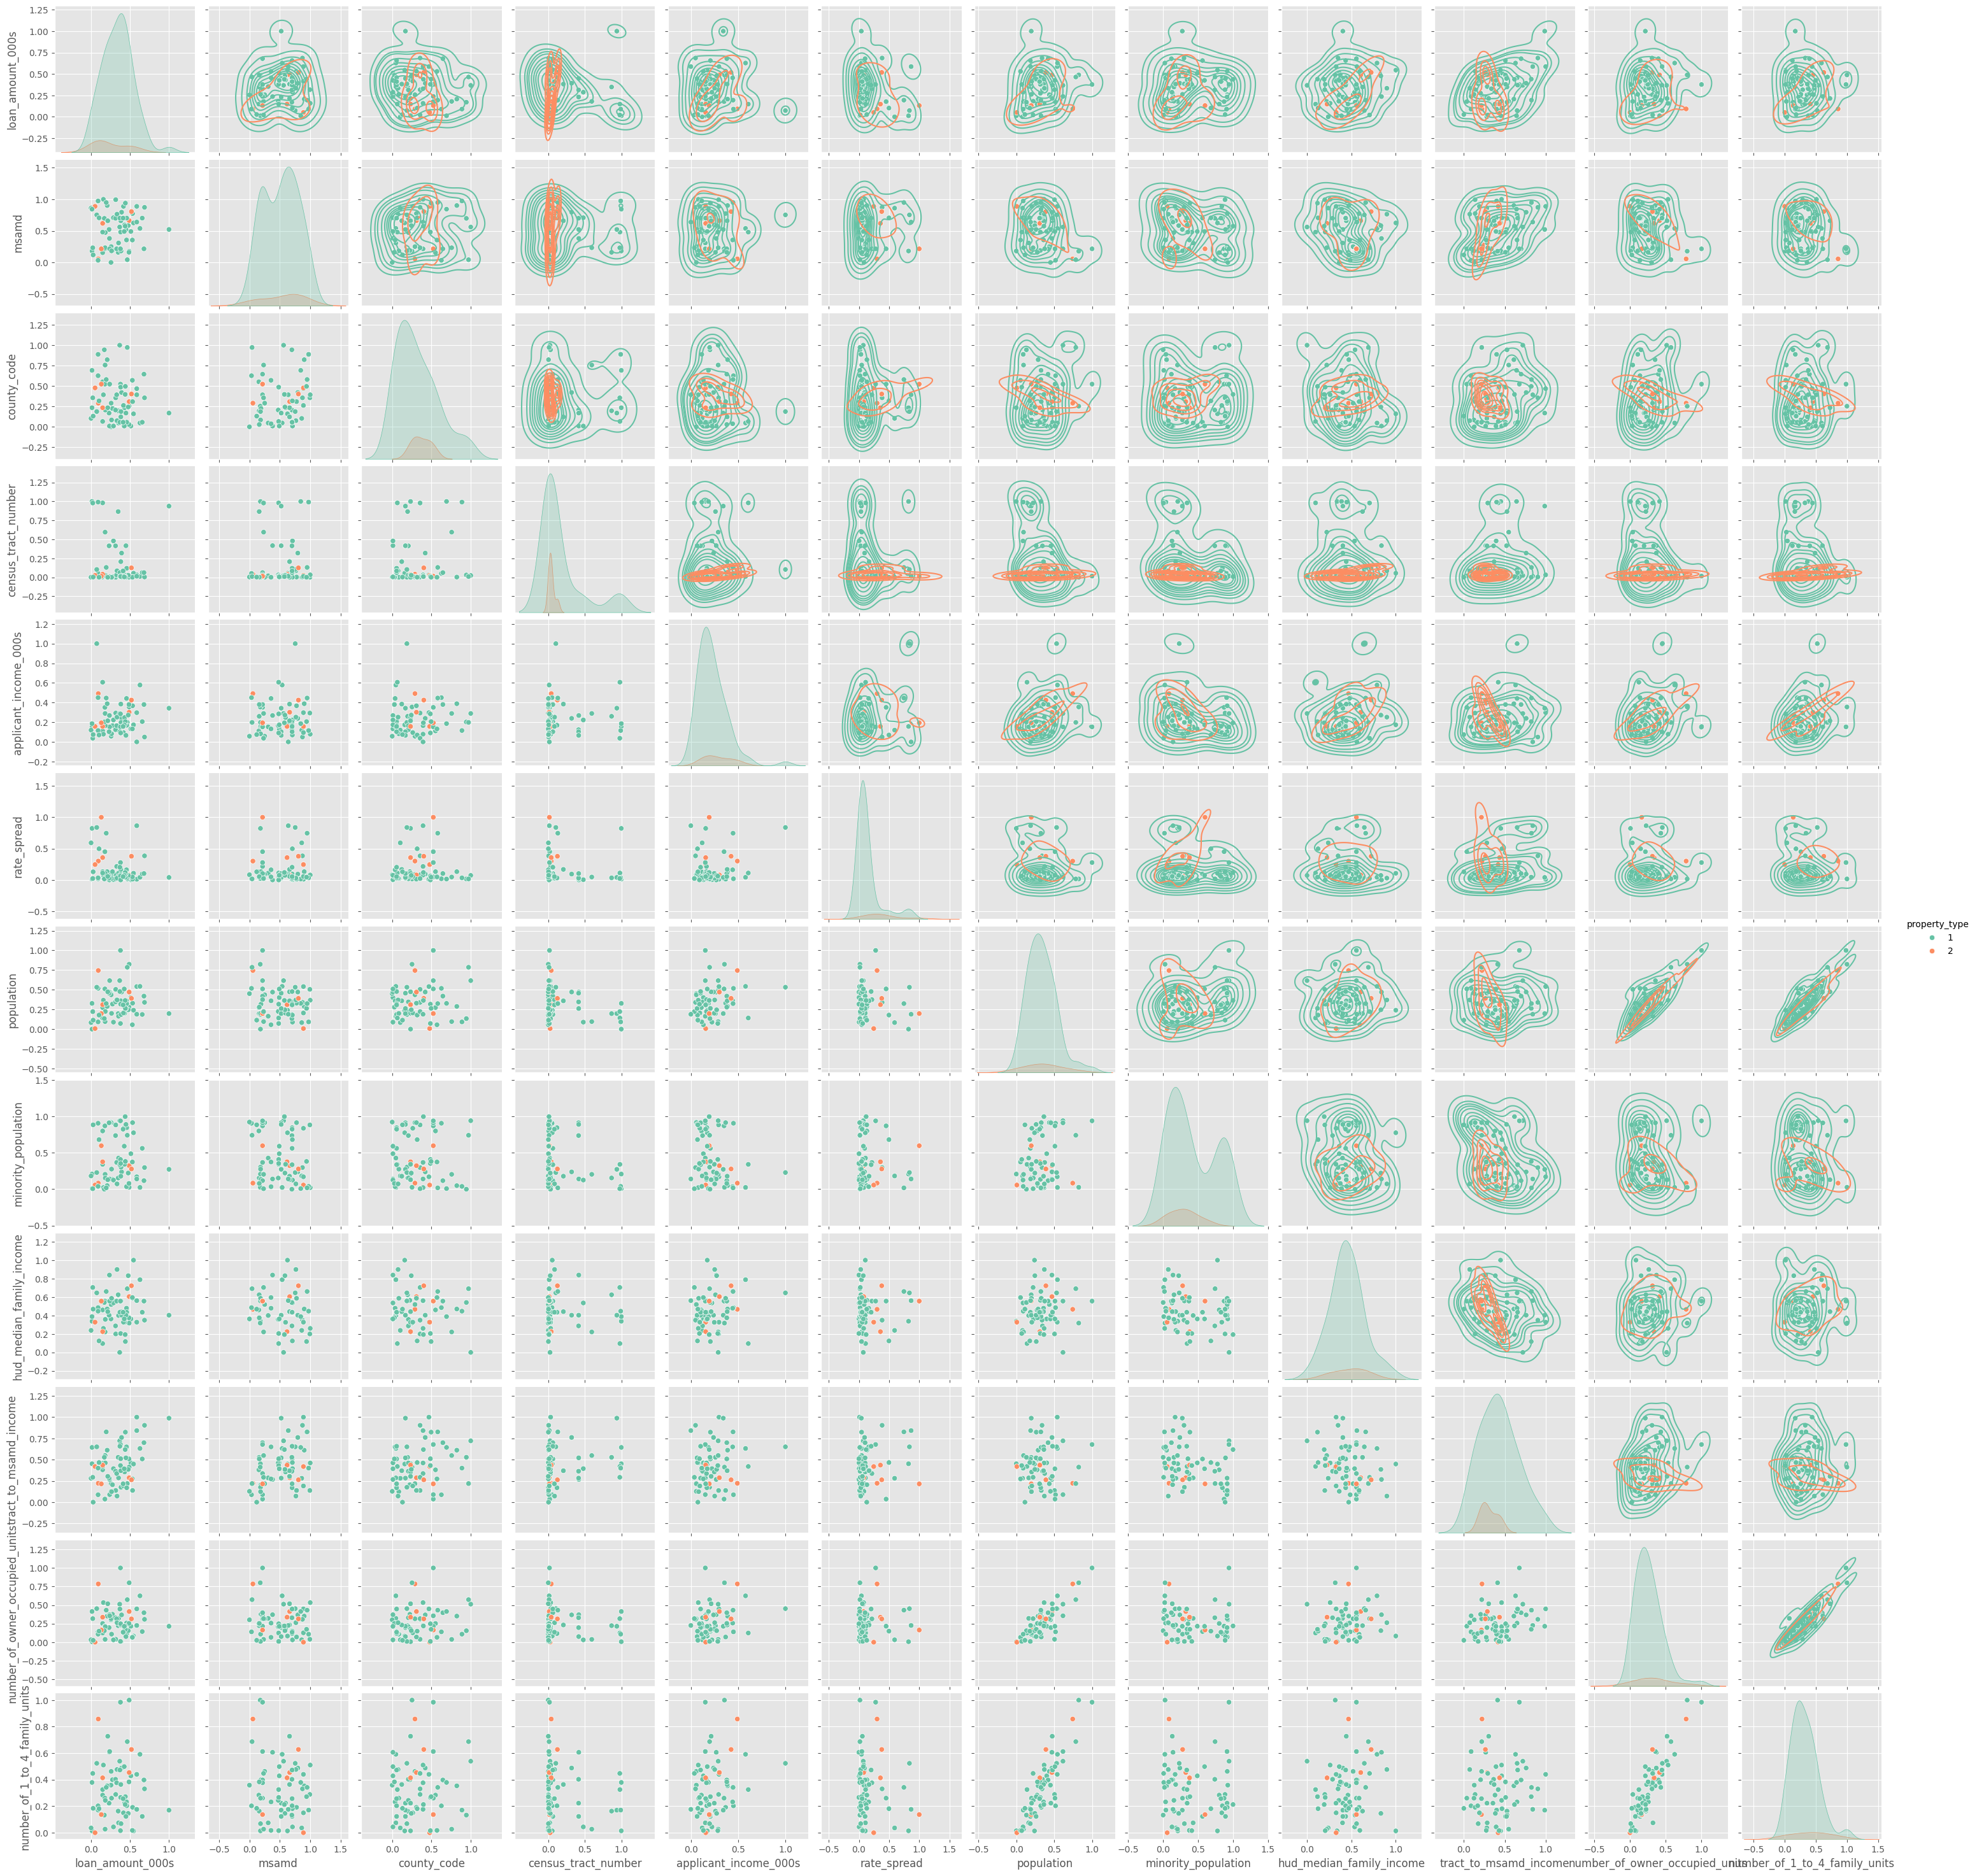

In [51]:
from sklearn.preprocessing import MinMaxScaler

random_sample_scaler = MinMaxScaler()

random_sample = frame.sample(frac=0.001)
scaled_sample = pd.DataFrame(
    random_sample_scaler.fit_transform(random_sample[numerical_columns].values),
    index=random_sample.index,
    columns=numerical_columns,
)
scaled_sample['property_type'] = random_sample['property_type']

plot = sns.pairplot(
    scaled_sample,
    palette='Set2',
    hue='property_type',
    diag_kind='kde',
    aspect=1)
plot.map_upper(sns.kdeplot)

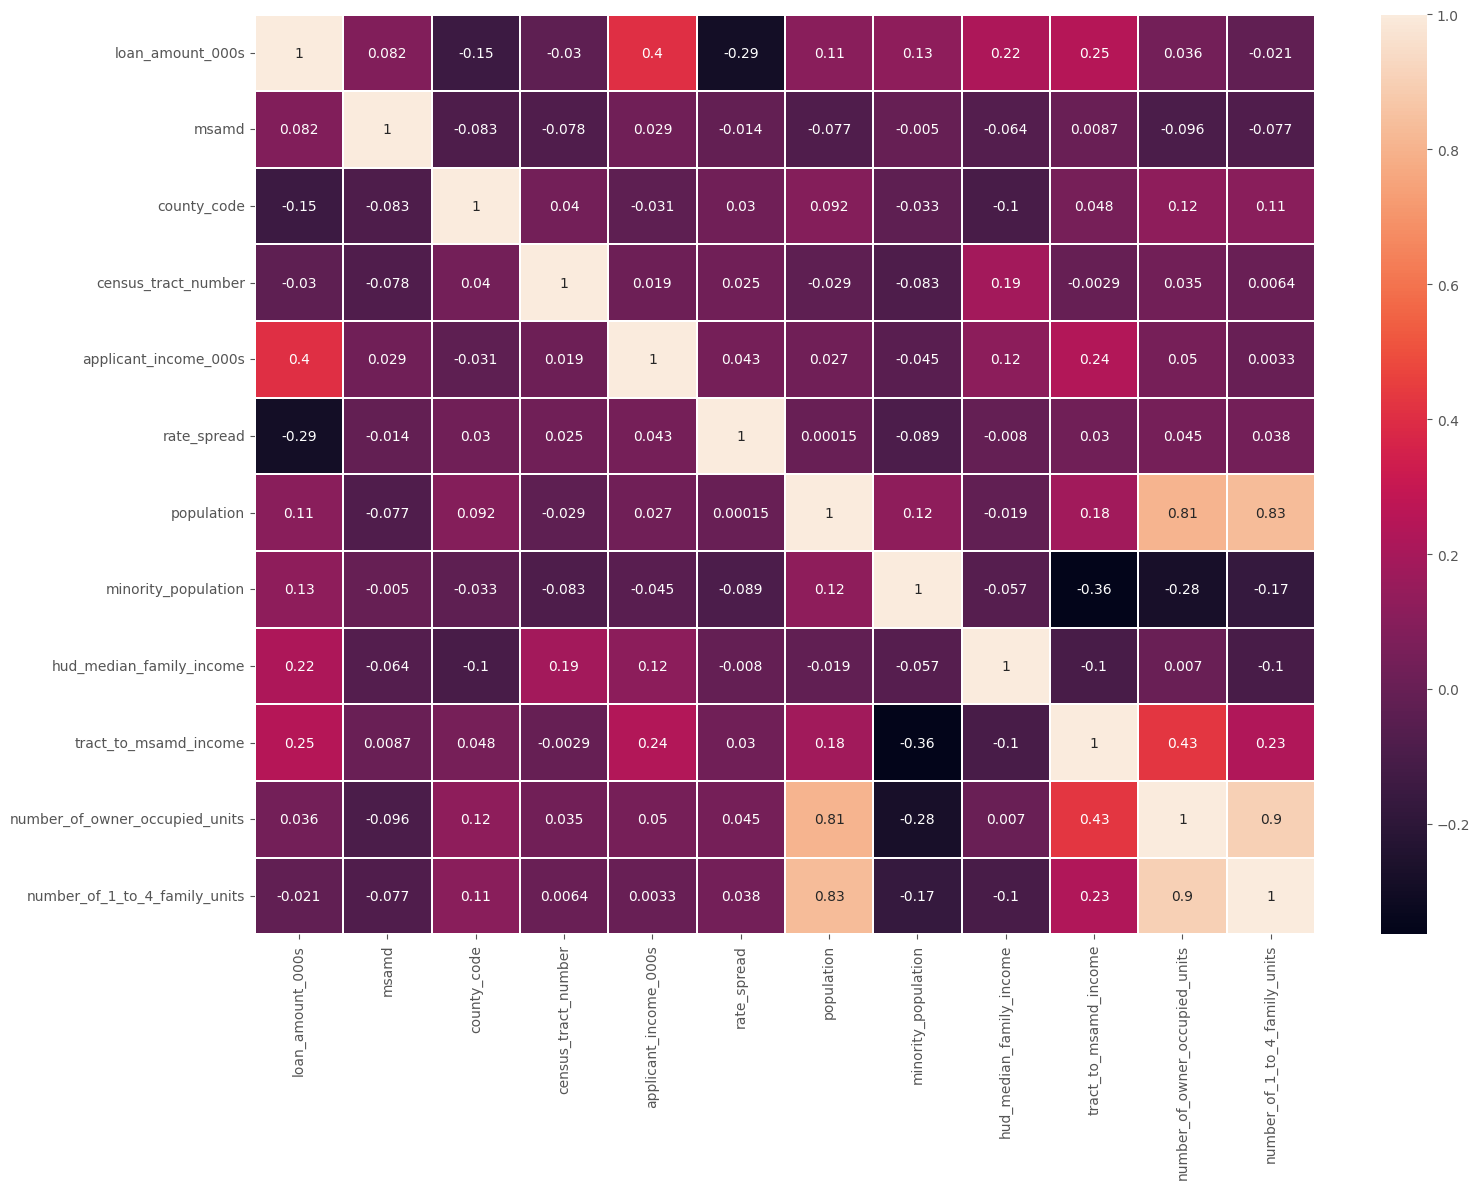

In [54]:
fig, axs = plt.subplots(
    figsize=(16, 12)
)

sns.heatmap(
    data=frame[numerical_columns].corr(), 
    annot=True,
    linewidths=0.2,
    ax=axs
)

fig.tight_layout()
plt.show()